In [2]:
import torch
from communityaware.utils import load_dataset
from statsmodels.stats.proportion import binom_test, proportion_confint
import numpy as np
from communityaware.cert import anisotropic, sparsity
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set_context('paper')

In [3]:
config = {'data':{
    'source': 'tudataset',
    'name': 'MUTAG',
    'train_split': 0.8,
    'test_split': 0.1
}}

dataset = load_dataset(config)

In [4]:
y_test = dataset.testset_labels.numpy()
votes = torch.load('../output/MUTAG/votes/0.04_0.2').numpy()
print('Votes accuracy', np.mean((votes.argmax(axis=1) == y_test)))

Votes accuracy 0.7368421052631579


In [5]:
P = (0.04, 0.2)

confidence_level = 0.99


smoothed_prediction =  votes.argmax(1)
p_A = proportion_confint(votes.max(1), votes.sum(1), alpha=2 * (1-confidence_level), method='beta')[0]
abstain = p_A <= 0.5

print('p_A min', np.min(p_A))
print('abstain', np.mean(abstain))
print('Correct', np.mean(votes.argmax(1) == y_test))

p_A min 0.5909193949116669
abstain 0.0
Correct 0.7368421052631579


In [6]:
def certificate_grid(p_A, P, max_R, sparsity_aware=False):
    grid = np.zeros(max_R)
    for i in range(max_R[0]):
        for j in range(max_R[1]):
            if i == 0 and j == 0:
                grid[i][j] = p_A
            else:
                if sparsity_aware:
                    grid[i][j] = float(sparsity(R=(i, j), P=P, p_A=p_A))
                else:
                    grid[i][j] = float(anisotropic(R=(i, j), P=P, p_A=p_A))
    return grid

Text(0.5, 41.7, 'Edge additions')

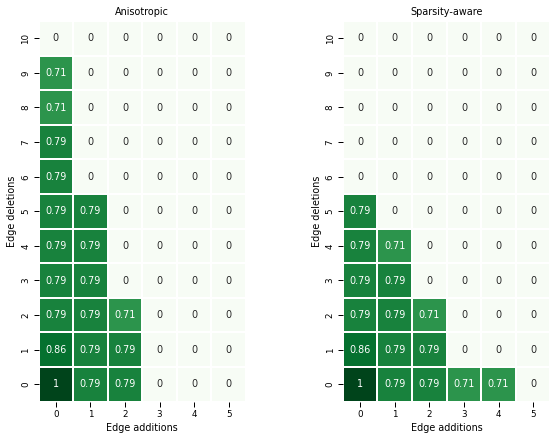

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
cmap = mpl.colormaps['Greens']
plot_kwargs = {'cmap': cmap, 'square': True, 'linewidth': 0.01, 'annot': True, 'cbar': False}

all_grids = []
max_R=(6, 11)
for i, p_a in enumerate(p_A):
    if not (votes.argmax(1) == y_test)[i] or abstain[i]:
        pass
    else:
        grid = certificate_grid(p_a, P, max_R, sparsity_aware=False)
        grid = (grid.T > 0.5).astype(float) 
        all_grids.append(grid)
grid = np.array(all_grids).mean(0)

sns.heatmap(grid, ax=ax1, **plot_kwargs)
ax1.set_title('Anisotropic')

all_grids = []
for i, p_a in enumerate(p_A):
    if not (votes.argmax(1) == y_test)[i] or abstain[i]:
        pass
    else:
        grid = certificate_grid(p_a, P, max_R, sparsity_aware=True)
        grid = (grid.T > 0.5).astype(float) 
        all_grids.append(grid)
grid = np.array(all_grids).mean(0)

sns.heatmap(grid, ax=ax2, **plot_kwargs)
ax2.set_title('Sparsity-aware')

ax1.invert_yaxis()
ax2.invert_yaxis()

ax1.set_xlim(0, 6)
ax2.set_xlim(0, 6)
ax1.set_ylim(0, 11)
ax2.set_ylim(0, 11)

ax1.set_ylabel('Edge deletions')
ax2.set_ylabel('Edge deletions')
ax1.set_xlabel('Edge additions')
ax2.set_xlabel('Edge additions')

#fig.savefig('figures/sparsity_comp.eps', format='eps', bbox_inches='tight')

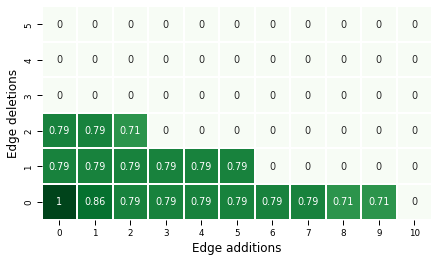

In [14]:
fig, ax = plt.subplots(figsize=(7, 5), )
plot_kwargs = {'cmap': cmap, 'square': True, 'linewidth': 0.01, 'annot': True, 'cbar': False}

all_grids = []
max_R=(6, 11)
for i, p_a in enumerate(p_A):
    if not (votes.argmax(1) == y_test)[i] or abstain[i]:
        pass
    else:
        grid = certificate_grid(p_a, P, max_R, sparsity_aware=False)
        grid = (grid.T > 0.5).astype(float) 
        all_grids.append(grid)
grid = np.array(all_grids).mean(0)

sns.heatmap(grid.T, ax=ax, **plot_kwargs)
#ax.set_title('Anisotropic')
ax.invert_yaxis()
ax.set_xlim(0, 11)
ax.set_ylim(0, 6)
ax.set_ylabel('Edge deletions', fontsize=12)
ax.set_xlabel('Edge additions', fontsize=12)

fig.savefig('../figures/comparison_anis.eps', format='eps', bbox_inches='tight')
fig.savefig('../figures/comparison_anis.png', format='png', bbox_inches='tight', facecolor='#EEEEEE', dpi=1000)

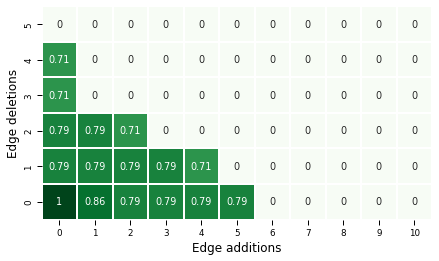

In [17]:
fig, ax = plt.subplots(figsize=(7, 5))
plot_kwargs = {'cmap': cmap, 'square': True, 'linewidth': 0.01, 'annot': True, 'cbar': False}

all_grids = []
max_R=(6, 11)
for i, p_a in enumerate(p_A):
    if not (votes.argmax(1) == y_test)[i] or abstain[i]:
        pass
    else:
        grid = certificate_grid(p_a, P, max_R, sparsity_aware=True)
        grid = (grid.T > 0.5).astype(float) 
        all_grids.append(grid)
grid = np.array(all_grids).mean(0)

sns.heatmap(grid.T, ax=ax, **plot_kwargs)
#ax.set_title('Sparsity-aware', fontsize=14)
ax.invert_yaxis()
ax.set_xlim(0, 11)
ax.set_ylim(0, 6)
ax.set_ylabel('Edge deletions', fontsize=12)
ax.set_xlabel('Edge additions', fontsize=12)

fig.savefig('../figures/comparison_sparse.eps', format='eps', bbox_inches='tight')
fig.savefig('../figures/comparison_sparse.png', format='png', bbox_inches='tight', facecolor='#EEEEEE', dpi=1000)